# Enhanced Preprocessing Code with CLAHE Normalization

In [1]:
import cv2
import os
import numpy as np

def detect_and_crop_moon(image_path, output_folder, is_no_moon=False):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return False
    if is_no_moon:
        output_path = os.path.join(output_folder, os.path.basename(image_path))
        cv2.imwrite(output_path, image)
        return True
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        (x, y), radius = cv2.minEnclosingCircle(largest_contour)
        center = (int(x), int(y))
        radius = int(radius)
        
        y_min = max(center[1] - radius, 0)
        y_max = min(center[1] + radius, image.shape[0])
        x_min = max(center[0] - radius, 0)
        x_max = min(center[0] + radius, image.shape[1])
        cropped = image[y_min:y_max, x_min:x_max]
        
        if cropped.size == 0:
            print(f"Invalid cropping for {image_path}")
            return False
        
        lab = cv2.cvtColor(cropped, cv2.COLOR_BGR2LAB)
        l_channel, a_channel, b_channel = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        clahe_l = clahe.apply(l_channel)
        enhanced_lab = cv2.merge((clahe_l, a_channel, b_channel))
        enhanced = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
        
        output_path = os.path.join(output_folder, os.path.basename(image_path))
        cv2.imwrite(output_path, enhanced)
        return True
    else:
        print(f"No moon detected in {image_path}")
        return False

def process_dataset(input_folder, output_folder):
    for phase_folder in os.listdir(input_folder):
        phase_path = os.path.join(input_folder, phase_folder)
        if os.path.isdir(phase_path):
            output_phase_path = os.path.join(output_folder, phase_folder)
            os.makedirs(output_phase_path, exist_ok=True)
            for image_name in os.listdir(phase_path):
                image_path = os.path.join(phase_path, image_name)
                is_no_moon = phase_folder.lower() in ['new moon', 'no moon']
                if detect_and_crop_moon(image_path, output_phase_path, is_no_moon):
                    print(f"Processed {image_path}")
                else:
                    print(f"Failed to process {image_path}")

input_folder = 'Moon'  
output_folder = 'Preprocess_Moon'  
process_dataset(input_folder, output_folder)

Processed Moon/new moon/masa1.jpeg
Processed Moon/new moon/nm22.jpeg
Processed Moon/new moon/nm19.jpeg
Processed Moon/new moon/1.jpeg
Processed Moon/new moon/nm24.jpeg
Processed Moon/new moon/nm7.jpeg
Processed Moon/new moon/nm28.jpeg
Processed Moon/new moon/nm12.jpeg
Processed Moon/new moon/nm13.jpeg
Processed Moon/new moon/nm25.jpeg
Processed Moon/new moon/nm30.jpeg
Processed Moon/new moon/nm5.jpeg
Processed Moon/new moon/nm26.jpeg
Processed Moon/new moon/nm10.jpeg
Processed Moon/new moon/nm9.jpeg
Processed Moon/new moon/nm8.jpeg
Processed Moon/new moon/nm11.jpeg
Processed Moon/new moon/nm16.jpeg
Processed Moon/new moon/nm3.jpeg
Processed Moon/new moon/nm20.jpeg
Processed Moon/new moon/nm21.jpeg
Processed Moon/new moon/nm17.jpeg
Processed Moon/waxing gibbous/a9.jpeg
Processed Moon/waxing gibbous/1192.jpeg
Processed Moon/waxing gibbous/1096.jpeg
Processed Moon/waxing gibbous/349.jpeg
Processed Moon/waxing gibbous/826.jpeg
Processed Moon/waxing gibbous/830.jpeg
Processed Moon/waxing gi

# Model Training Code

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# Custom preprocessing function for Lambda layer
def effnet_preprocess(img):
    return preprocess_input(img)

# Function to calculate class weights
def calculate_class_weights(data_dir, class_names):
    all_labels = []
    for label_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        all_labels.extend([label_idx] * len(os.listdir(class_dir)))
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
    return dict(enumerate(class_weights))

# Dataset loading
base_dir = 'Preprocess_Moon/'  
img_size = 224  
batch = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123,
    validation_split=0.2,
    subset='training',
    batch_size=batch,
    image_size=(img_size, img_size)
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123,
    validation_split=0.2,
    subset='validation',
    batch_size=batch,
    image_size=(img_size, img_size)
)

class_names = train_ds.class_names
print("Class Names:", class_names)
class_weights = calculate_class_weights(base_dir, class_names)
print("Class Weights:", class_weights)

# Enhanced data augmentation
data_augmentation = Sequential([
    layers.RandomBrightness(factor=0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomContrast(0.3),
    layers.GaussianNoise(0.02),
])

# Dataset optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Improved model architecture
def create_model():
    inputs = layers.Input(shape=(img_size, img_size, 3))
    
    # Apply data augmentation
    x = data_augmentation(inputs)
    
    # EfficientNet preprocessing with named function
    x = tf.keras.layers.Lambda(effnet_preprocess)(x)
    
    # Base model
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x)
    base_model.trainable = True
    for layer in base_model.layers[:150]:
        layer.trainable = False
    
    # Classification head
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(class_names), activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Training setup
model = create_model()

# Callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluation
train_loss, train_accuracy = model.evaluate(train_ds)
val_loss, val_accuracy = model.evaluate(val_ds)
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Found 1250 files belonging to 9 classes.
Using 1000 files for training.
Found 1250 files belonging to 9 classes.
Using 250 files for validation.
Class Names: ['first quarter', 'full moon', 'new moon', 'no moon', 'third quarter', 'waning crescent', 'waning gibbous', 'waxing crescent', 'waxing gibbous']
Class Weights: {0: np.float64(1.3354700854700854), 1: np.float64(0.6645401382243488), 2: np.float64(6.313131313131313), 3: np.float64(0.46296296296296297), 4: np.float64(1.2512512512512513), 5: np.float64(1.1200716845878136), 6: np.float64(1.4029180695847363), 7: np.float64(0.9259259259259259), 8: np.float64(1.0602205258693809)}
Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 402ms/step - accuracy: 0.1584 - loss: 2.9104 - val_accuracy: 0.4440 - val_loss: 2.3845 - learning_rate: 1.0000e-04
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 389ms/step - accuracy: 0.4710 - loss: 2.3405 - val_accuracy: 0.7360 - val_loss: 1.7367 - learning_rate: 1.0000e-04
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 453ms/s

In [3]:
# Model saving
model.save('MoonArcModel.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step
Predicted Label: first quarter


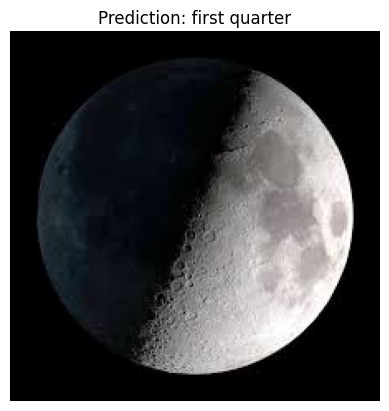

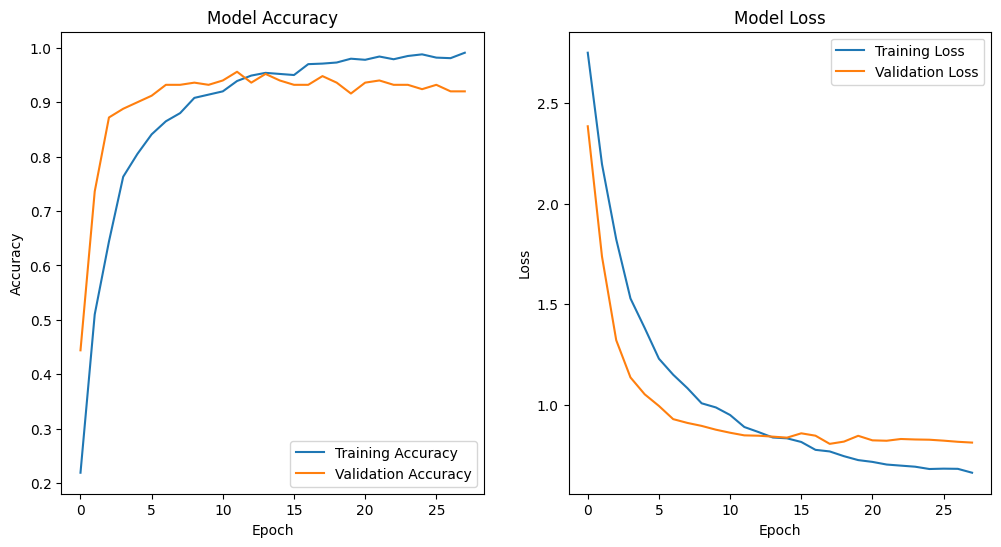

In [4]:
# Threshold-based prediction
def predict_with_threshold(image, model, threshold=0.5):
    """
    Predict the moon phase or 'no-moon' if the confidence is below the threshold.

    Args:
        image: Preprocessed image tensor.
        model: Trained TensorFlow model.
        threshold: Confidence threshold for detecting 'no-moon'.

    Returns:
        Predicted class or 'no-moon'.
    """
    predictions = model.predict(tf.expand_dims(image, axis=0))
    max_prob = np.max(predictions)
    if max_prob < threshold:
        return "no-moon"
    else:
        predicted_class = np.argmax(predictions)
        return class_names[predicted_class]

# Example Usage
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_path = 'tested images/fr.jpeg' 
image = load_img(image_path, target_size=(img_size, img_size))
image_array = img_to_array(image)
image_array = preprocess_input(image_array)

# Predict with threshold
predicted_label = predict_with_threshold(image_array, model, threshold=0.5)
print("Predicted Label:", predicted_label)

# Plot the test image
plt.imshow(image)
plt.title(f"Prediction: {predicted_label}")
plt.axis('off')
plt.show()

# Plotting accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()